In [1]:
from torchvision.models import resnet18# type: ignore
import medmnist
from medmnist import DermaMNIST
from medmnist import INFO, Evaluator
from matplotlib import transforms
from torchvision import transforms
import torch.utils.data as data
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from collections import Counter

In [ ]:
data_flag = 'dermamnist'
download = False

NUM_EPOCHS = 20
BATCH_SIZE = 32
lr = 0.003

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']             
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [3]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert('RGB') if x.mode == 'L' else x),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    # Small zoom + crop around original size
    # transforms.RandomResizedCrop(size=28, scale=(0.9, 1.1))
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10, fill=0),            # random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),     # random brightness/contrast
    transforms.ToTensor(),
    normalize,
])

val_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert('RGB') if x.mode == 'L' else x),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

test_transform = val_transform

pil_dataset = DermaMNIST(split='train', download=download)
train_dataset = DermaMNIST(split='train', transform=train_transform, download=False)
train_dataset_at_eval = DermaMNIST(split='train', transform=val_transform, download=False)
val_dataset   = DermaMNIST(split='val',   transform=val_transform, download=False)
test_dataset  = DermaMNIST(split='test',  transform=test_transform, download=False)

train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True) # type: ignore
train_loader_at_eval = data.DataLoader(dataset=train_dataset_at_eval, batch_size=2*BATCH_SIZE, shuffle=False) # type: ignore
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE,   shuffle = False) # type: ignore
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False) # type: ignore

In [4]:
label_counts = Counter()
for _, label in train_dataset:
    label_counts[label.item()] += 1

num_classes = len(label_counts)
counts = np.array([label_counts[c] for c in range(num_classes)], dtype=np.float32)

class_weights = 1.0 / (counts + 1e-6)
class_weights = class_weights / class_weights.sum() * num_classes
class_weights = torch.tensor(class_weights, dtype=torch.float32)

In [5]:
pretrained_model = resnet18(weights='IMAGENET1K_V1')

for param in pretrained_model.parameters():
    param.requires_grad = True

pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, n_classes)

# Unfreeze the new head
for param in pretrained_model.fc.parameters():
    param.requires_grad = True

model = pretrained_model

# Loss and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss(weight=class_weights)
else:
    criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)


In [ ]:
# Training loop      
store_train = []
store_val = []

patience = 5
best_val = float('inf')
patience_ctr = 0
best_path = "best_resnet18.pth"

for epoch in range(NUM_EPOCHS):
    running_train_loss = 0.0
    running_train_count = 0
    running_val_loss = 0.0
    running_val_count = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        bs = inputs.size(0)
        running_train_loss += loss.item() * bs
        running_train_count += bs
    
    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader):
            outputs = model(inputs)
            
            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                loss_val = criterion(outputs, targets)
            else:
                targets = targets.squeeze().long()
                loss_val = criterion(outputs, targets)
            bs = inputs.size(0)
            running_val_loss += loss_val.item() * bs
            running_val_count += bs

    epoch_train_loss = running_train_loss / running_train_count
    epoch_val_loss = running_val_loss / running_val_count

    scheduler.step(epoch_val_loss)

    store_train.append(epoch_train_loss)
    store_val.append(epoch_val_loss)

    if epoch_val_loss < best_val:
        best_val = epoch_val_loss
        patience_ctr = 0
        torch.save(model.state_dict(), best_path)  # Save best model
        print(f"  → Saved best model (val_loss: {best_val:.4f})")
    else:
        patience_ctr += 1
        if patience_ctr >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print('Epoch [{}/{}], Loss: {:.4f}, Val Loss: {:.4f}'
          .format(epoch+1, NUM_EPOCHS, epoch_train_loss, epoch_val_loss))

 15%|█▍        | 32/219 [04:34<28:27,  9.13s/it]

==> Detailed Evaluation ...

TRAIN SET EVALUATION
AUC: 0.9273
Accuracy: 0.6632
Precision (weighted): 0.7602
Recall (weighted): 0.6632
F1-Score (weighted): 0.6924

------------------------------------------------------------
PER-CLASS METRICS:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.33      0.64      0.44       228
           1       0.51      0.68      0.58       359
           2       0.42      0.47      0.45       769
           3       0.27      0.60      0.37        80
           4       0.34      0.58      0.43       779
           5       0.94      0.70      0.80      4693
           6       0.44      0.96      0.61        99

    accuracy                           0.66      7007
   macro avg       0.46      0.66      0.53      7007
weighted avg       0.76      0.66      0.69      7007



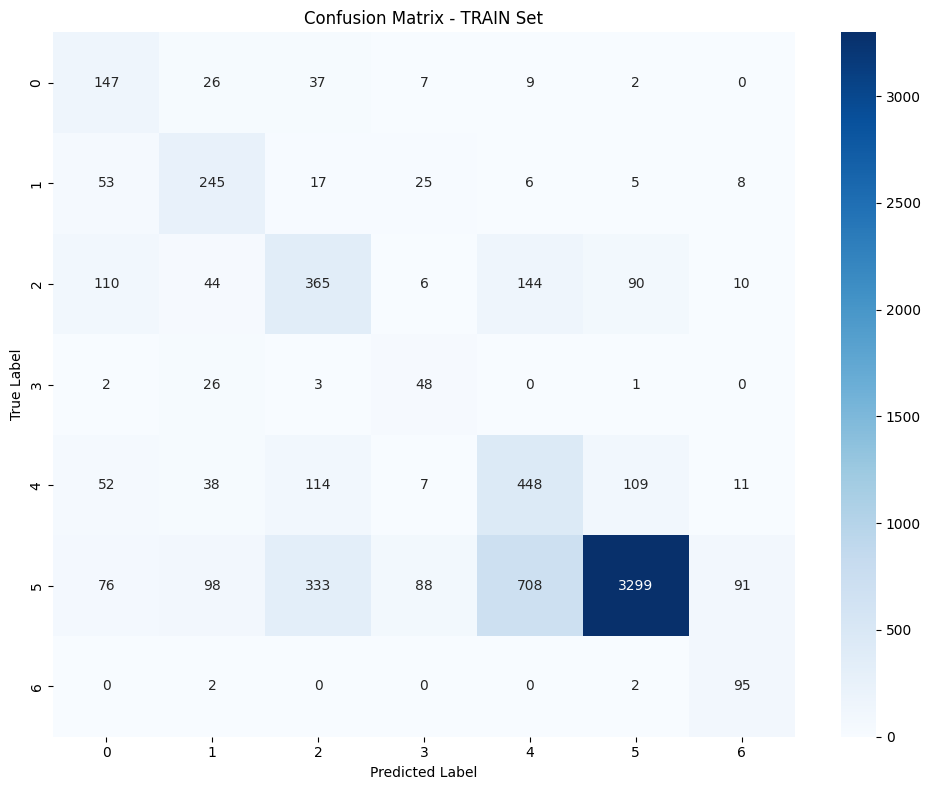


------------------------------------------------------------
CLASS DISTRIBUTION:
------------------------------------------------------------
Class 0: 228 samples (3.25%)
Class 1: 359 samples (5.12%)
Class 2: 769 samples (10.97%)
Class 3: 80 samples (1.14%)
Class 4: 779 samples (11.12%)
Class 5: 4693 samples (66.98%)
Class 6: 99 samples (1.41%)

TEST SET EVALUATION
AUC: 0.9151
Accuracy: 0.6479
Precision (weighted): 0.7506
Recall (weighted): 0.6479
F1-Score (weighted): 0.6794

------------------------------------------------------------
PER-CLASS METRICS:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.30      0.58      0.39        66
           1       0.44      0.64      0.52       103
           2       0.42      0.45      0.44       220
           3       0.19      0.39      0.26        23
           4       0.34      0.59      0.43       223
           5       0.94      0.69      0.80      134

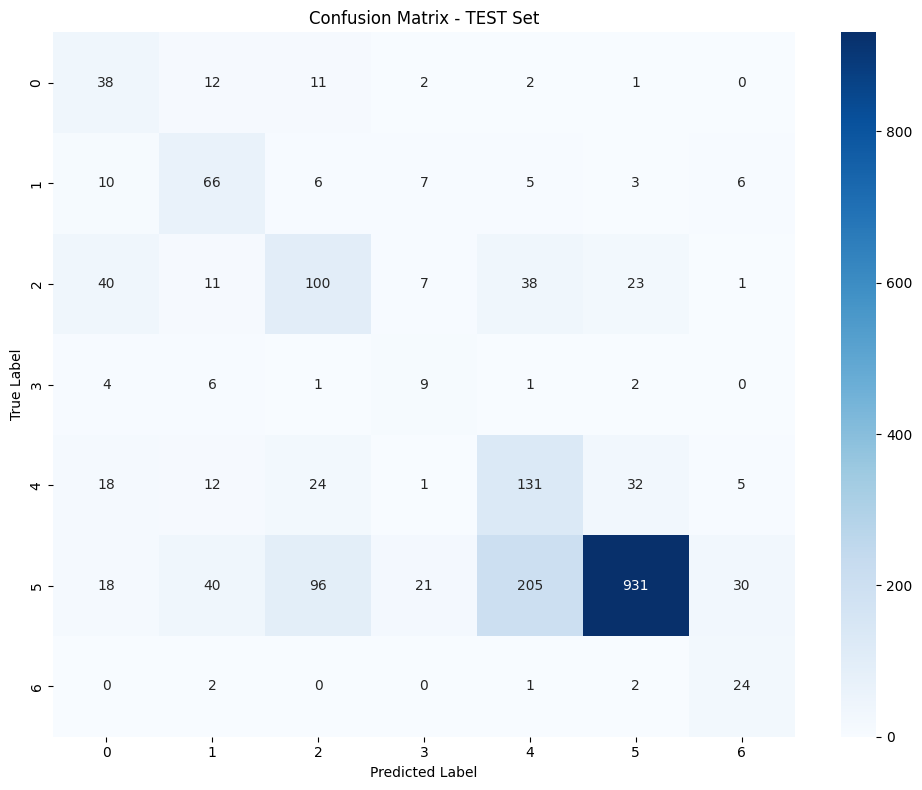


------------------------------------------------------------
CLASS DISTRIBUTION:
------------------------------------------------------------
Class 0: 66 samples (3.29%)
Class 1: 103 samples (5.14%)
Class 2: 220 samples (10.97%)
Class 3: 23 samples (1.15%)
Class 4: 223 samples (11.12%)
Class 5: 1341 samples (66.88%)
Class 6: 29 samples (1.45%)

SUMMARY COMPARISON
Metric               Train           Test           
------------------------------------------------------------
Accuracy             0.6632           0.6479
AUC                  0.9273           0.9151
Precision            0.7602           0.7506
Recall               0.6632           0.6479
F1-Score             0.6924           0.6794


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

def detailed_test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    y_pred = torch.tensor([])
    
    data_loader = test_loader if split == 'test' else train_loader_at_eval

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                
                # Get predictions (argmax)
                preds = outputs.argmax(dim=1)
                y_pred = torch.cat((y_pred, preds.float()), 0)
                
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy().astype(int).flatten()
        y_score = y_score.detach().numpy()
        y_pred = y_pred.numpy().astype(int)
        
        # Standard metrics (AUC and Accuracy)# Skin_disease_detection_system
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
        print(f'\n{"="*60}')
        print(f'{split.upper()} SET EVALUATION')
        print(f'{"="*60}')
        print(f'AUC: {metrics[0]:.4f}')
        print(f'Accuracy: {metrics[1]:.4f}')
        
        # Additional metrics
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        
        print(f'Precision (weighted): {precision:.4f}')
        print(f'Recall (weighted): {recall:.4f}')
        print(f'F1-Score (weighted): {f1:.4f}')
        
        # Per-class metrics
        print(f'\n{"-"*60}')
        print('PER-CLASS METRICS:')
        print(f'{"-"*60}')
        print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(n_classes)], zero_division=0))
        
        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=range(n_classes), 
                    yticklabels=range(n_classes))
        plt.title(f'Confusion Matrix - {split.upper()} Set')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
        
        # Class distribution
        unique, counts = np.unique(y_true, return_counts=True)
        print(f'\n{"-"*60}')
        print('CLASS DISTRIBUTION:')
        print(f'{"-"*60}')
        for cls, count in zip(unique, counts):
            print(f'Class {cls}: {count} samples ({count/len(y_true)*100:.2f}%)')
        
        return {
            'auc': metrics[0],
            'accuracy': metrics[1],
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'confusion_matrix': cm,
            'y_true': y_true,
            'y_pred': y_pred,
            'y_score': y_score
        }

# Evaluate on both train and test sets
print('==> Detailed Evaluation ...')
train_results = detailed_test('train')
test_results = detailed_test('test')

# Summary comparison
print(f'\n{"="*60}')
print('SUMMARY COMPARISON')
print(f'{"="*60}')
print(f'{"Metric":<20} {"Train":<15} {"Test":<15}')
print(f'{"-"*60}')
print(f'{"Accuracy":<20} {train_results["accuracy"]:.4f}{"":<10} {test_results["accuracy"]:.4f}')
print(f'{"AUC":<20} {train_results["auc"]:.4f}{"":<10} {test_results["auc"]:.4f}')
print(f'{"Precision":<20} {train_results["precision"]:.4f}{"":<10} {test_results["precision"]:.4f}')
print(f'{"Recall":<20} {train_results["recall"]:.4f}{"":<10} {test_results["recall"]:.4f}')
print(f'{"F1-Score":<20} {train_results["f1"]:.4f}{"":<10} {test_results["f1"]:.4f}')
print(f'{"="*60}')

In [ ]:
"""
Fine Tuning                      
learning rate scheduling - Helps to improve accuracy            
increase epoch -
decrease batch size - 
use better backbone -
data transforms - Done
better optimizer - Need to try with diffrent SGD vs AdamW
early stopping - Extermly useful we don't know the right number of epoch we should run on 
Apply class weights - Used for class Imbalance which is the case in our dataset
better comparisons
more layers to be frozen - Freezing one block is enough
"""